In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from graph_tool.all import *

/home/ubuntu/anaconda3/envs/gt2/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:1494: RuntimeWarning: Error importing Gtk module: No module named 'gi'; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


In [3]:
# Create df using only rows that are relevant as the whole file is too large. We did this by sequentially loading chunks
# of data to filter for which observations are in the time frame of relevance.

df1 = pd.read_csv('stackoverflow.Posts.csv', 
                  names= ['AnswerCount', 'Body', 'CommentCount', 'CreationDate', 'Id', 'LastActivityDate',
                          'LastEditDate', 'LastEditorUserId', 'OwnerUserId', 'ParentId', 'PostTypeId', 'Score', 
                          'Tags', 'Title', 'Viewcount', '_id'],
                  skiprows=3000000, nrows=9000000)

# Finding first year of Graph-Tool mentions

In [4]:
# Searching body, title and tag of each question to look for when graph-tool or equivalent first appeared and isolating all 
# questions about it within the first year after. Create lists containing all the nodes that participated in Graph-Tool 
# threads within the first year after the first post

dfGT = df1.dropna(subset=['Body','Tags','Title'])
dfGT = dfGT[dfGT['Body'].str.contains("graph-tool|graph tool|graph_tool", case=False)| 
          dfGT['Tags'].str.contains("graph-tool|graph tool|graph_tool", case=False)|
          dfGT['Title'].str.contains("graph-tool|graph tool|graph_tool", case=False)] 
dfGT = dfGT.loc[(dfGT['CreationDate'] > '2011-03-28') & (dfGT['CreationDate'] < '2011-09-28')]
dfGT = dfGT.dropna(subset=['OwnerUserId'])
EarlyAdopters = list(dfGT['OwnerUserId'])
Questions = list(dfGT['Id'])

# Very first tag is 2011-03-28

In [5]:
# Use the list of question Ids to find any nodes that replied to threads about Graph-tool in first year, however the data 
# does not suggest any answers were given.

df3 = df1
mask = (df3['CreationDate'] > '2011-03-28') & (df3['CreationDate'] <= '2011-09-28')
df3 = df3.loc[mask]
df3 = df3[df3['ParentId'].isin(Questions)]

In [6]:
Innovators = [434376,172590,736855,779849,766994,383679,512993,274589,734691,651687,413301,73660,526367,172590,265570]

In [7]:
Adopters = [807867,936215,73226,898071,889614]

# Creating DataFrame to build network

In [8]:
# 6 months of prior data is used to build the network as otherwise there is too much to plot so we only use data from 
# 2011-10-04 onwards.

df2 = df1
df2['CreationDate'] = df2['CreationDate'].astype('datetime64[D]')
mask = (df2['CreationDate'] > '2011-02-28') & (df2['CreationDate'] <= '2011-03-28')
df2 = df2.loc[mask]

In [9]:
# Df with information on just questions posted

dfQ = df2.loc[df2['PostTypeId'] ==1]
dfQ = dfQ[['Id','OwnerUserId']]
dfQ['ParentId']=dfQ['Id']

In [10]:
# Df with information on just answers to questions

dfA = df2.loc[df1['PostTypeId'] ==2]
dfA = dfA[['OwnerUserId','ParentId','CreationDate']]
dfA = dfA.astype({"ParentId": int})

In [11]:
# Merging df containing questions and answers so that each observation contains 2 nodes to link and time period. Also, drop
# all NaN values.

dfFinal = dfA.merge(dfQ,on='ParentId')
dfFinal = dfFinal[['OwnerUserId_x','OwnerUserId_y']]
dfFinal = dfFinal.rename(columns={"OwnerUserId_x": "Id_x", "OwnerUserId_y": "Id_y"})
dfFinal = dfFinal.dropna(subset=['Id_x','Id_y'])
dfFinal = dfFinal.astype({"Id_x":int,"Id_y":int})

In [12]:
n = list(set(dfFinal['Id_x']))
n.extend(list(set(dfFinal['Id_y'])))
n = list(set(n))
list.sort(n)

In [13]:
len(n)

54417

In [14]:
Nodes = np.arange(54417)
new = pd.DataFrame(Nodes,n)
new['UserID'] = n
new['Nodes'] = new[0]

In [15]:
dfNew = dfFinal
dct = pd.Series(new.Nodes.values,index=new.UserID).to_dict()
dfNew['Id_x'] = dfNew.Id_x.map( dct )
dfNew['Id_y'] = dfNew.Id_y.map( dct )

In [16]:
index = new.loc[(new['UserID'].isin(Innovators)) | (new['UserID'].isin(Adopters))]

In [17]:
print(Innovators, Adopters)

[434376, 172590, 736855, 779849, 766994, 383679, 512993, 274589, 734691, 651687, 413301, 73660, 526367, 172590, 265570] [807867, 936215, 73226, 898071, 889614]


In [18]:
index

,0,UserID,Nodes
73226,5078,73226,5078
73660,5098,73660,5098
265570,15766,265570,15766
274589,16235,274589,16235
413301,23336,413301,23336
434376,24449,434376,24449
512993,29015,512993,29015
526367,29768,526367,29768
651687,43300,651687,43300


# Network

In [19]:
g = Graph(directed=False)

In [20]:
g.add_edge_list(dfNew.values.tolist())

In [21]:
g

<Graph object, undirected, with 54417 vertices and 157968 edges at 0x7f5f2faf5e48>

In [23]:
state = graph_tool.inference.minimize_blockmodel_dl(g)

In [24]:
print(state)

<BlockState object with 48 blocks (48 nonempty), degree-corrected, for graph <Graph object, undirected, with 54417 vertices and 157968 edges at 0x7ffb6cd4ef28>, at 0x7ffa9de2c780>


In [22]:
state1 = graph_tool.inference.minimize_nested_blockmodel_dl(g)

In [23]:
state1.print_summary()

l: 0, N: 54417, B: 91
l: 1, N: 91, B: 31
l: 2, N: 31, B: 9
l: 3, N: 9, B: 2
l: 4, N: 2, B: 1


In [27]:
lstate = state1.levels[0]
ustate = state1.levels[1]

In [31]:
index

,0,UserID,Nodes
73226,5078,73226,5078
73660,5098,73660,5098
265570,15766,265570,15766
274589,16235,274589,16235
413301,23336,413301,23336
434376,24449,434376,24449
512993,29015,512993,29015
526367,29768,526367,29768
651687,43300,651687,43300


In [31]:
b = lstate.get_blocks()
print(b[5078], b[5098], b[15766], b[16235], b[23336], b[24449], b[29015], b[29768], b[43300])

46 34 2 38 34 53 22 35 6


In [35]:
print(graph_tool.stats.vertex_average(g,'total'))

(5.8058327360935005, 0.05814650582810529)


In [42]:
levels = state1.get_levels()
for s in levels:
    print(s)

<BlockState object with 86 blocks (86 nonempty), degree-corrected, for graph <Graph object, undirected, with 54417 vertices and 157968 edges at 0x7ffb6cd4ef28>, at 0x7ffabbaf6470>
<BlockState object with 38 blocks (38 nonempty), for graph <Graph object, undirected, with 86 vertices and 2850 edges at 0x7ffb55e7dc18>, at 0x7ffa5e87a9b0>
<BlockState object with 14 blocks (14 nonempty), for graph <Graph object, undirected, with 38 vertices and 667 edges at 0x7ffa56c384a8>, at 0x7ffab04c2630>
<BlockState object with 5 blocks (5 nonempty), for graph <Graph object, undirected, with 14 vertices and 89 edges at 0x7ffab04c2898>, at 0x7ffab04bc860>
<BlockState object with 2 blocks (2 nonempty), for graph <Graph object, undirected, with 5 vertices and 15 edges at 0x7ffa5e87a3c8>, at 0x7ffabbaf6a20>
<BlockState object with 1 blocks (1 nonempty), for graph <Graph object, undirected, with 2 vertices and 3 edges at 0x7ffa5e87a438>, at 0x7ffa56c3d358>


In [43]:
r = levels[0].get_blocks()[5078]    # group membership of node 46 in level 0
print(r)
r = levels[0].get_blocks()[r]     # group membership of node 46 in level 1
print(r)
r = levels[0].get_blocks()[r]     # group membership of node 46 in level 1
print(r)
r = levels[0].get_blocks()[r]     # group membership of node 46 in level 1
print(r)

50
29
19
12


# Degree Distribution

In [33]:
# get node in-degree
hist = vertex_hist(g, "total")

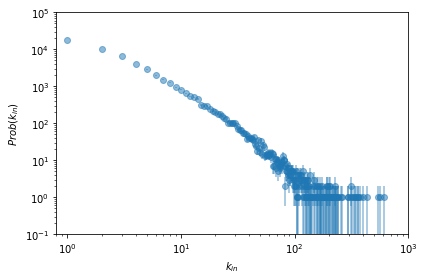

In [34]:
# data series
# --+ point estimates
y = hist[0]
# --+ confidence interval
err = np.sqrt(hist[0])
err[err >= y] = y[err >= y] - 1e-2

# create figure
fig = plt.figure(figsize=(6,4))


ax = fig.add_subplot(1, 1, 1)

# plot data with Matplotlib errorbar
ax.errorbar(hist[1][:-1], hist[0],
         fmt="o", alpha=0.5,
         yerr=err,
         label="in")

# axes
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(1e-1, 1e5)
ax.set_xlim(0.8, 1e3)


# labels
ax.set_xlabel("$k_{in}$")
ax.set_ylabel("$Prob(k_{in})$")

# save figure
fig.tight_layout()

plt.savefig('Degrees.png')
plt.show()

In [43]:
nodelist = list(index['Nodes'])

In [46]:
nodelist

[5078, 5098, 15766, 16235, 23336, 24449, 29015, 29768, 43300]

In [45]:
print(g.get_total_degrees(nodelist))

[171  15   1  10   4  31  29  55  14]


In [38]:
index

,0,UserID,Nodes
73226,5078,73226,5078
73660,5098,73660,5098
265570,15766,265570,15766
274589,16235,274589,16235
413301,23336,413301,23336
434376,24449,434376,24449
512993,29015,512993,29015
526367,29768,526367,29768
651687,43300,651687,43300


# NetworkX

In [3]:
DF1 = pd.read_csv('stackoverflow.Posts.csv', 
                  names= ['AnswerCount', 'Body', 'CommentCount', 'CreationDate', 'Id', 'LastActivityDate',
                          'LastEditDate', 'LastEditorUserId', 'OwnerUserId', 'ParentId', 'PostTypeId', 'Score', 
                          'Tags', 'Title', 'Viewcount', '_id'],
                  skiprows=2, nrows=6000000)

In [4]:
DFNX = DF1.dropna(subset=['Body','Tags','Title'])
DFNX = DFNX[DFNX['Body'].str.contains("networkx|network-x", case=False)| 
          DFNX['Tags'].str.contains("networkx|network-x", case=False)|
          DFNX['Title'].str.contains("networkx|network-x", case=False)] 
# First mention is 2009-05-07

In [5]:
DFNX = DFNX.loc[(DFNX['CreationDate'] > '2009-05-07') & (DFNX['CreationDate'] < '2009-11-07')]
DFNX = DFNX.dropna(subset=['OwnerUserId'])
EarlyAdoptersX = list(DFNX['OwnerUserId'])
QuestionsX = list(DFNX['Id'])

In [6]:
DFNX1 = DFNX.loc[(DFNX['CreationDate']<'2009-08-07')]

In [7]:
DFNX2 = DFNX.loc[(DFNX['CreationDate']>'2009-08-07')]

In [8]:
DF3 = DF1
mask = (DF3['CreationDate'] > '2009-05-07') & (DF3['CreationDate'] <= '2009-11-07')
DF3 = DF3.loc[mask]
DF3 = DF3[DF3['ParentId'].isin(QuestionsX)]

In [9]:
DF31 = DF3.loc[(DF3['CreationDate']<'2009-08-07')]

In [10]:
DF32 = DF3.loc[(DF3['CreationDate']>'2009-08-07')]

In [11]:
InnovatorsX = list(set(DFNX1['OwnerUserId']))
InnovatorsX.extend(list(set(DF31['OwnerUserId'])))
InnovatorsX = list(set(InnovatorsX))


In [12]:
AdoptersX = list(set(DFNX2['OwnerUserId']))
AdoptersX.extend(list(set(DF32['OwnerUserId'])))
AdoptersX = list(set(AdoptersX))

In [13]:
print(InnovatorsX,AdoptersX)

[65696.0, 95810.0, 108130.0, 94404.0, 17160.0, 15369.0, 93004.0, 80204.0, 50831.0, 88879.0, 55281.0, 108687.0, 85140.0, 101430.0, 115866.0, 117052.0, 42973.0, 14558.0] [164546.0, 141826.0, 100322.0, 60617.0, 155726.0, 18936.0, 145403.0]


In [14]:
DF2 = DF1
DF2['CreationDate'] = DF2['CreationDate'].astype('datetime64[D]')
mask = (DF2['CreationDate'] > '2009-04-07') & (DF2['CreationDate'] <= '2009-05-07')
DF2 = DF2.loc[mask]

In [15]:
DFQ = DF2.loc[DF2['PostTypeId'] ==1]
DFQ = DFQ[['Id','OwnerUserId']]
DFQ['ParentId']=DFQ['Id']

In [16]:
DFA = DF2.loc[DF1['PostTypeId'] ==2]
DFA = DFA[['OwnerUserId','ParentId','CreationDate']]
DFA = DFA.astype({"ParentId": int})

In [17]:
DFFinal = DFA.merge(DFQ,on='ParentId')
DFFinal = DFFinal[['OwnerUserId_x','OwnerUserId_y']]
DFFinal = DFFinal.rename(columns={"OwnerUserId_x": "Id_x", "OwnerUserId_y": "Id_y"})
DFFinal = DFFinal.dropna(subset=['Id_x','Id_y'])
DFFinal = DFFinal.astype({"Id_x":int,"Id_y":int})

In [18]:
n = list(set(DFFinal['Id_x']))
n.extend(list(set(DFFinal['Id_y'])))
n = list(set(n))
list.sort(n)

In [19]:
len(n)

12722

In [20]:
Nodes = np.arange(12722)
New = pd.DataFrame(Nodes,n)
New['UserID'] = n
New['Nodes'] = New[0]

In [21]:
DFNew = DFFinal
dct = pd.Series(New.Nodes.values,index=New.UserID).to_dict()
DFNew['Id_x'] = DFNew.Id_x.map( dct )
DFNew['Id_y'] = DFNew.Id_y.map( dct )

In [22]:
Xindex = New.loc[(New['UserID'].isin(InnovatorsX)) | (New['UserID'].isin(AdoptersX))]

In [23]:
Xindex

,0,UserID,Nodes
14558,2454,14558,2454
15369,2543,15369,2543
17160,2746,17160,2746
18936,2947,18936,2947
60617,6758,60617,6758
65696,7239,65696,7239
85140,9219,85140,9219
88879,9743,88879,9743
94404,10793,94404,10793
95810,11039,95810,11039


In [24]:
print(InnovatorsX,AdoptersX)

[65696.0, 95810.0, 108130.0, 94404.0, 17160.0, 15369.0, 93004.0, 80204.0, 50831.0, 88879.0, 55281.0, 108687.0, 85140.0, 101430.0, 115866.0, 117052.0, 42973.0, 14558.0] [164546.0, 141826.0, 100322.0, 60617.0, 155726.0, 18936.0, 145403.0]


In [30]:
G = Graph(directed=False)

In [31]:
G.add_edge_list(DFNew.values.tolist())

In [32]:
stateX = graph_tool.inference.minimize_nested_blockmodel_dl(G)

In [33]:
print(stateX)

<NestedBlockState object, with base <BlockState object with 22 blocks (22 nonempty), degree-corrected, for graph <Graph object, undirected, with 12722 vertices and 52891 edges at 0x7f29d027c080>, at 0x7f2980cb9048>, and 3 levels of sizes [(12722, 22), (22, 4), (4, 1)] at 0x7f293f8eddd8>


In [34]:
stateX.print_summary()

l: 0, N: 12722, B: 22
l: 1, N: 22, B: 4
l: 2, N: 4, B: 1


In [35]:
Xstate = stateX.levels[0]

In [38]:
Xindex

,0,UserID,Nodes
14558,2454,14558,2454
15369,2543,15369,2543
17160,2746,17160,2746
18936,2947,18936,2947
60617,6758,60617,6758
65696,7239,65696,7239
85140,9219,85140,9219
88879,9743,88879,9743
94404,10793,94404,10793
95810,11039,95810,11039


In [39]:
c = Xstate.get_blocks()
print(c[2454], c[2543], c[2746] ,c[2947], c[7239], c[9219], c[9743], c[10793], c[11039], c[11864], c[12064])

3 15 15 18 4 0 14 14 15 15 15


In [59]:
Xlist = list(Xindex['Nodes'])

In [61]:
print(G.get_total_degrees(Xlist))

[ 5 29 71 39  1  3 85 15]


In [62]:
InnovatorsX

[65696.0,
 95810.0,
 108130.0,
 17160.0,
 93004.0,
 80204.0,
 88879.0,
 50831.0,
 55281.0,
 108687.0,
 85140.0,
 115866.0,
 117052.0,
 42973.0,
 14558.0]

In [64]:
AdoptersX

[164546.0, 141826.0, 100322.0, 155726.0, 18936.0]

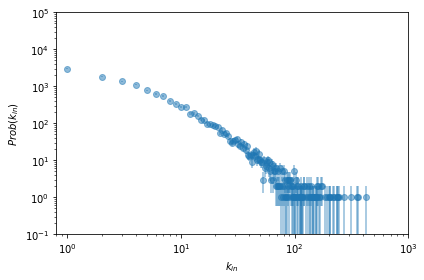

In [42]:
hist = vertex_hist(G, "total")
# data series
# --+ point estimates
Y = hist[0]
# --+ confidence interval
err = np.sqrt(hist[0])
err[err >= Y] = Y[err >= Y] - 1e-2

# create figure
fig = plt.figure(figsize=(6,4))


ax = fig.add_subplot(1, 1, 1)

# plot data with Matplotlib errorbar
ax.errorbar(hist[1][:-1], hist[0],
         fmt="o", alpha=0.5,
         yerr=err,
         label="in")

# axes
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(1e-1, 1e5)
ax.set_xlim(0.8, 1e3)


# labels
ax.set_xlabel("$k_{in}$")
ax.set_ylabel("$Prob(k_{in})$")

# save figure
fig.tight_layout()

plt.savefig('Degrees2.png')
plt.show()